In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from itertools import combinations, product
import warnings
import logging

warnings.simplefilter("ignore")
logging.basicConfig(level=logging.INFO)

time: 561 µs (started: 2022-10-25 13:50:54 +00:00)


# Load or Create Correlation Data

In [14]:
# setting of output files
save_raw_corr_data = False
save_train_info_arima_resid_data = False
# data implement setting
data_implement = "sp500_20082017_consumer_discretionary"  # tw50|sp500_20082017|sp500_19972007|tetuan_power
                                                          # |sp500_20082017_consumer_discretionary
# train set setting
items_setting = "train"  # train|all

time: 434 µs (started: 2022-10-25 13:50:55 +00:00)


In [15]:
# data loading & implement setting
dataset_path = Path("../dataset/")
if data_implement == "tw50":
    file_name = Path("tw50_hold_20082018_adj_close_pre.csv")
    train_set = ['萬海_adj_close', '豐泰_adj_close', '友達_adj_close', '欣興_adj_close', '台塑化_adj_close', '和泰車_adj_close', '元大金_adj_close', '南電_adj_close', '台塑_adj_close', '統一超_adj_close', '台泥_adj_close', '瑞昱_adj_close', '彰銀_adj_close', '富邦金_adj_close', '研華_adj_close', '中鋼_adj_close', '鴻海_adj_close', '台新金_adj_close', '遠傳_adj_close', '南亞_adj_close', '台達電_adj_close', '台灣大_adj_close', '台化_adj_close', '聯詠_adj_close', '廣達_adj_close', '聯發科_adj_close', '台積電_adj_close', '統一_adj_close', '中信金_adj_close', '長榮_adj_close']
elif data_implement == "sp500_19972007":
    file_name = Path("sp500_hold_19972007_adj_close_pre.csv")
    train_set = ['PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'NEM', 'CTAS', 'MAT', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'CI', 'ZION', 'COO', 'FDX', 'GLW', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'BMY', 'KMB', 'JPM', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'WMB', 'IFF', 'CMS', 'MMC', 'REG', 'ES', 'ITW', 'VRTX', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'VNO', 'WDC', 'PVH', 'NOC', 'PCAR', 'NSC', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'ALK', 'TAP', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'HIG', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'CMA', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG']
elif data_implement in ["sp500_20082017", "paper_eva_1", "paper_eva_2", "paper_eva_3", "paper_eva_4", "paper_eva_5"]:
    file_name = Path("sp500_hold_20082017_adj_close_pre.csv")
    train_set = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
elif data_implement == "tetuan_power":
    file_name = Path("Tetuan City power consumption_pre.csv")
    train_set = ["Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows", "Zone 1 Power Consumption", "Zone 2 Power Consumption", "Zone 3 Power Consumption"]
elif data_implement == "sp500_20082017_consumer_discretionary":
    file_name = Path("sp500_hold_20082017_adj_close_pre_consumer_discretionary.csv")
    train_set = ['LKQ', 'LEN', 'TGT', 'YUM', 'TJX', 'GRMN', 'MCD', 'DRI', 'HBI', 'GPS', 'SBUX', 'TSCO', 'WYN', 'MGM', 'MAT', 'ROST', 'IPG', 'PVH', 'VFC', 'EXPE', 'JWN', 'GPC', 'DIS', 'FL', 'AAP', 'KSS', 'TIF', 'HAS', 'DHI', 'MHK', 'UAA', 'KMX', 'BBY', 'CMCSA', 'LEG', 'VIAB', 'CCL', 'LB', 'HOG', 'F', 'AZO', 'RL', 'DISCA', 'FOXA', 'PHM', 'AMZN', 'WHR', 'NKE', 'SNA', 'M', 'FOX', 'ULTA', 'GT', 'CMG', 'LOW', 'TWX', 'HD', 'CBS']


dataset_df = pd.read_csv(dataset_path/file_name)
dataset_df = dataset_df.set_index('Date')
all_set = list(dataset_df.columns.values[1:])  # all data
test_set = [p for p in all_set if p not in train_set]  # all data - train data
logging.info(f"===== len(train_set): {len(train_set)}, len(all_set): {len(all_set)}, len(test_set): {len(test_set)} =====")

# train set setting
if items_setting == "all":
    items_set = all_set
    output_set_name = "_all"
elif items_setting == "train":
    items_set = train_set
    output_set_name = "_train"
train_info = {"tw50": {"items":items_set, "file_name": "tw50_20082017"},
              "sp500_19972007": {"items":items_set, "output_file_name_basis": f"sp500_19972007"},
              "sp500_20082017": {"items": items_set, "output_file_name_basis": f"sp500_20082017"},
              "tetuan_power": {"items": items_set, "output_file_name_basis":  f"tetuan_power"},
              "sp500_20082017_consumer_discretionary": {"items": items_set, "output_file_name_basis":  f"sp500_20082017_consumer_discretionary"}}
items_implement = train_info[data_implement]['items']
logging.info(f"===== len(train set): {len(items_implement)} =====")

# setting of name of output files and pictures title
output_file_name = train_info[data_implement]['output_file_name_basis'] + output_set_name
logging.info(f"===== file_name basis:{output_file_name} =====")

# display(dataset_df)

INFO:root:===== len(train_set): 58, len(all_set): 67, len(test_set): 10 =====
INFO:root:===== len(train set): 58 =====
INFO:root:===== file_name basis:sp500_20082017_consumer_discretionary_train =====


time: 20.5 ms (started: 2022-10-25 13:50:56 +00:00)


In [16]:
def gen_data_corr(items: list, corr_ind: list) -> "pd.DataFrame":
    tmp_corr = dataset_df[items[0]].rolling(window=100).corr(dataset_df[items[1]])
    tmp_corr = tmp_corr.iloc[corr_ind].values
    data_df = pd.DataFrame(tmp_corr.reshape(-1, 24), dtype="float32")
    ind = [f"{items[0]} & {items[1]}_{i}" for i in range(0, 100, 20)]
    data_df.index = ind
    return data_df


def gen_train_data(items: list, corr_ind: list, save_file: bool = False)-> "four pd.DataFrame":
    train_df = pd.DataFrame(dtype="float32")
    dev_df = pd.DataFrame(dtype="float32")
    test1_df = pd.DataFrame(dtype="float32")
    test2_df = pd.DataFrame(dtype="float32")

    for pair in tqdm(combinations(items, 2)):
        data_df = gen_data_corr([pair[0], pair[1]], corr_ind=corr_ind)
        data_split = {'train': [0, 21], 'dev': [1, 22], 'test1': [2, 23], 'test2': [3, 24]}
        train_df = pd.concat([train_df, data_df.iloc[:, 0:21]])
        dev_df = pd.concat([dev_df, data_df.iloc[:, 1:22]])
        test1_df = pd.concat([test1_df, data_df.iloc[:, 2:23]])
        test2_df = pd.concat([test2_df, data_df.iloc[:, 3:24]])

    if save_file:
        before_arima_data_path = dataset_path/f"{output_file_name}_before_arima"
        before_arima_data_path.mkdir(parents=True, exist_ok=True)
        train_df.to_csv(before_arima_data_path/f"{output_file_name}_train.csv")
        dev_df.to_csv(before_arima_data_path/f"{output_file_name}_dev.csv")
        test1_df.to_csv(before_arima_data_path/f"{output_file_name}_test1.csv")
        test2_df.to_csv(before_arima_data_path/f"{output_file_name}_test2.csv")

    return train_df, dev_df, test1_df, test2_df


before_arima_data_path = dataset_path/f"{output_file_name}_before_arima"
train_df = before_arima_data_path/f"{output_file_name}_train.csv"
dev_df = before_arima_data_path/f"{output_file_name}_dev.csv"
test1_df = before_arima_data_path/f"{output_file_name}_test1.csv"
test2_df = before_arima_data_path/f"{output_file_name}_test2.csv"
if train_df.exists() and dev_df.exists() and test1_df.exists() and test2_df.exists():
    corr_datasets = (pd.read_csv(train_df), pd.read_csv(dev_df), pd.read_csv(test1_df), pd.read_csv(test2_df))
else:
    corr_ind = list(range(99, 2400, 100))  + list(range(99+20, 2500, 100)) + list(range(99+40, 2500, 100)) + list(range(99+60, 2500, 100)) + list(range(99+80, 2500, 100))
    # corr_datasets = gen_train_data(items_implement, corr_ind, save_file = save_raw_corr_data)

time: 57.3 ms (started: 2022-10-25 13:50:58 +00:00)


In [18]:
len(corr_datasets)

4

time: 1.35 ms (started: 2022-10-25 13:51:23 +00:00)


# Create Portfolio

out of 505 companies, 150 firms are randomly selected for the portfolio.

In [2]:
df = pd.read_csv("../../stock08_price.csv")
universe = list(df.columns.values[1:])
universe.remove("SP500")
# print(universe)

time: 104 ms (started: 2022-07-18 14:23:34 +00:00)


In [3]:
# train data
portfolio_train = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
# all data
portfolio_all = universe
# all data - train data
portfolio_other = [p for p in universe if p not in portfolio_train]
print(len(portfolio_train), len(portfolio_all), len(portfolio_other))

150 445 295
time: 1.55 ms (started: 2022-07-18 14:23:34 +00:00)


# Prepare the Data

In [4]:
def rolling_corr(item1,item2) :
    #import data
    stock_price_df = pd.read_csv("../../stock08_price.csv")
    pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_corr = df_pair[item1].rolling(window=100).corr(df_pair[item2])
    return df_corr


def gen_data(portfolio, file_name="", save_file=False):
    index_list = []
    for _ in range(100):
        indices = []
        for k in range(_, 2420,100):
            indices.append(k)
        index_list.append(indices)

    data_matrix = []
    count = 0
    for i in range(len(portfolio)):
        for j in range(len(portfolio)-1-i):
            a = portfolio[i]
            b = portfolio[len(portfolio)-1-j]
            corr_series = rolling_corr(a, b)[99:]
            for _ in range(100):
                corr_strided = list(corr_series[index_list[_]][:24]).copy()
                data_matrix.append(corr_strided)
                count+=1
                if count % 100000 == 0 :
                    print(str(count)+' items preprocessed')

    data_matrix = np.transpose(data_matrix)
    data_dictionary = {}
    for i in range(len(data_matrix)):
        data_dictionary[str(i)] = data_matrix[i]
    data_df = pd.DataFrame(data_dictionary)
    if save_file:
        data_df.to_csv(f'./correlation_record/{file_name}', index=False)
    return data_df


def gen_corr_series(data_df=None, file_name="", from_file=False, concat_all=True):
    if from_file:
        data_df = pd.read_csv(f'./correlation_record/{file_name}')
        data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
    ind_range = int(len(data_df)/20)
    num_list = []
    for i in range(24):
        num_list.append(str(i))
    data_df = data_df[num_list].copy()
    data_df = np.transpose(data_df)
    indices = [20*k for k in range(ind_range)]
    data_df = pd.DataFrame(data_df[indices])
    if concat_all:
        return data_df.values.reshape(-1,)
    else:
        return data_df



time: 1.81 ms (started: 2022-07-18 14:23:34 +00:00)


In [5]:
gen_from_file = True

if gen_from_file:
    train_corr_series_concat = gen_corr_series(None, "train_dataset.csv", from_file=True, concat_all=True)
    all_corr_series_concat = gen_corr_series(None, "445_dataset.csv", from_file=True, concat_all=True)
    other_corr_series_concat = gen_corr_series(None, "295_dataset.csv", from_file=True, concat_all=True)
else:
    train_data_df = gen_data(portfolio_train) 
    all_data_df = gen_data(portfolio_all) 
    other_data_df = gen_data(portfolio_other) 
    train_corr_series_concat = gen_corr_series(train_data_df)
    all_corr_series_concat = gen_corr_series(all_data_df)
    other_corr_series_concat = gen_corr_series(other_data_df)


time: 31.2 s (started: 2022-07-18 14:23:34 +00:00)


In [6]:
# display(train_data_df.shape, train_data_df)
# display(all_data_df.shape, all_data_df)
# display(other_data_df.shape, other_data_df)
display(train_corr_series_concat.shape, train_corr_series_concat)
display(all_corr_series_concat.shape, all_corr_series_concat)
display(other_corr_series_concat.shape, other_corr_series_concat)

(1341000,)

array([ 0.64686041,  0.51820911,  0.26509852, ..., -0.53164748,
       -0.48467624, -0.72861306])

(11854800,)

array([ 0.49777406,  0.23529682,  0.44683713, ..., -0.43884455,
       -0.61089478, -0.40945352])

(5203800,)

array([-0.33935619, -0.42858279,  0.21048828, ..., -0.43884455,
       -0.61089478, -0.40945352])

time: 7.99 ms (started: 2022-07-18 14:24:05 +00:00)


# plot correlation coffecient distribution of data

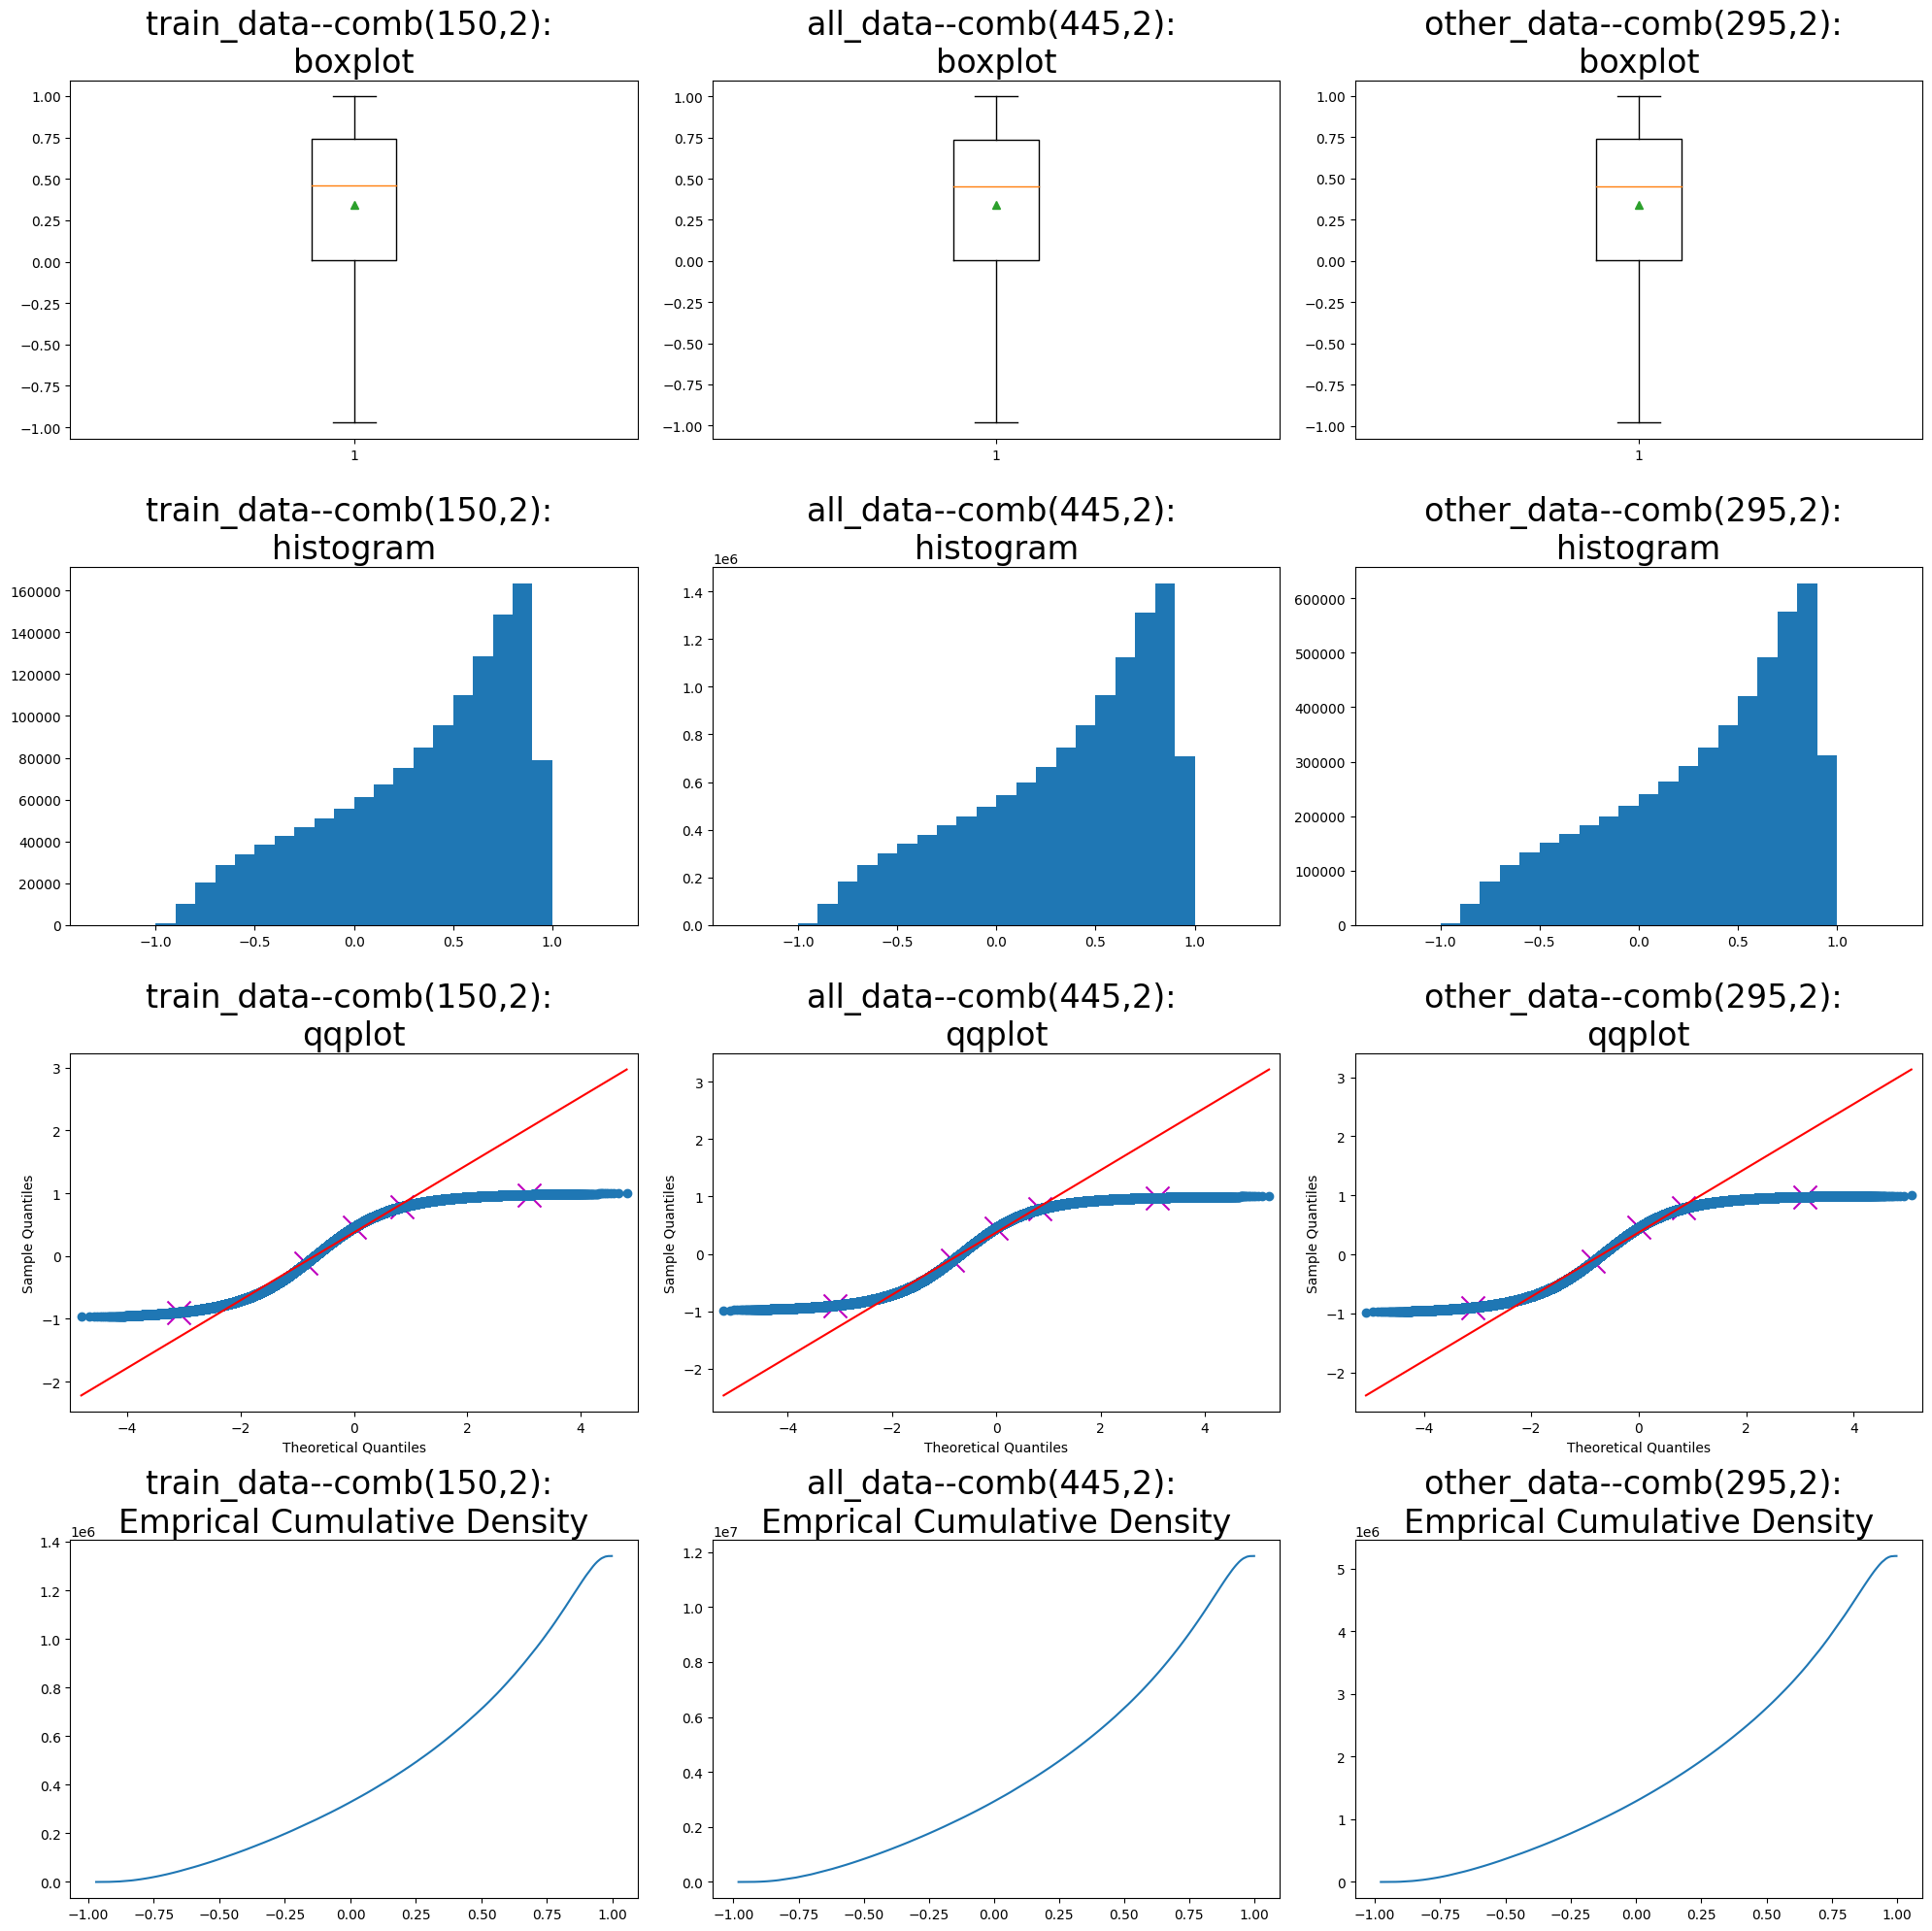

time: 1min 40s (started: 2022-07-18 14:24:05 +00:00)


In [7]:
datasets = {'train_data--comb(150,2)': train_corr_series_concat, 'all_data--comb(445,2)': all_corr_series_concat, 'other_data--comb(295,2)': other_corr_series_concat}
etl_types = ["boxplot", "histogram", "qqplot", "Emprical Cumulative Density"]
fig, axes = plt.subplots(figsize=(20, 20),nrows=len(etl_types), ncols=len(datasets), sharex=False, sharey=False, dpi=100)

for row, etl_type in enumerate(etl_types):
    for col,dataset_key in enumerate(datasets):
        # print(row, etl_type, col, dataset_key, datasets[dataset_key])
        s = axes[row, col]
        s.set_title(f"{dataset_key}: \n{etl_type}", fontsize=24)
        if etl_type=="boxplot":
            s.boxplot(datasets[dataset_key], showmeans=True)
        elif etl_type=="histogram":
            s.hist(datasets[dataset_key], bins=[b/10 for b in range(-13,14)])
        elif etl_type=="qqplot":
            percents = [0.001, 0.2, 0.5, 0.8, 0.999]
            #x,y = [norm.ppf(p) for p in percents], [np.quantile(train_corr_series_concat, p) for p in percents]
            x,y = [norm.ppf(p) for p in percents], [np.quantile(datasets[dataset_key], p) for p in percents]
            sm.qqplot(datasets[dataset_key], line='q', ax=s)
            s.scatter(x,y, c='m', marker='x', s=300)
        elif etl_type=="Emprical Cumulative Density":
            pd.Series(datasets[dataset_key]).value_counts().sort_index().cumsum().plot(ax=s)

# 分開, 避免子圖標籤互相重疊
plt.tight_layout()
plt.savefig("./results/dataset_exploration.png")
plt.show()
plt.close()

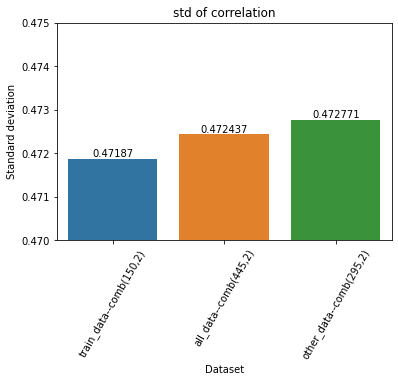

time: 124 ms (started: 2022-07-18 14:25:46 +00:00)


In [8]:
df = pd.DataFrame([[dataset_key, datasets[dataset_key].std()] for dataset_key in datasets], 
                  columns=['Dataset', 'Standard deviation'])
ax = sns.barplot(x='Dataset', y='Standard deviation', data=df)
ax.set_title('std of correlation')
ax.set(ylim=[0.47, 0.475])
ax.bar_label(ax.containers[0])
plt.xticks(rotation=60)
plt.savefig("./results/dataset_exploration_2.png")
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

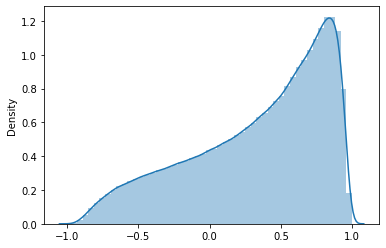

time: 3.13 s (started: 2022-07-18 14:25:46 +00:00)


In [9]:
sns.distplot(train_corr_series_concat)
# plt.hist(train_corr_series, bins=[b/10 for b in range(-13,14)])

In [10]:
train_corr_series_df = gen_corr_series(None, "train_dataset.csv", from_file=True, concat_all=False)
all_corr_series_df = gen_corr_series(None, "445_dataset.csv", from_file=True, concat_all=False)
other_corr_series_df = gen_corr_series(None, "295_dataset.csv", from_file=True, concat_all=False)

time: 30.9 s (started: 2022-07-18 14:25:49 +00:00)


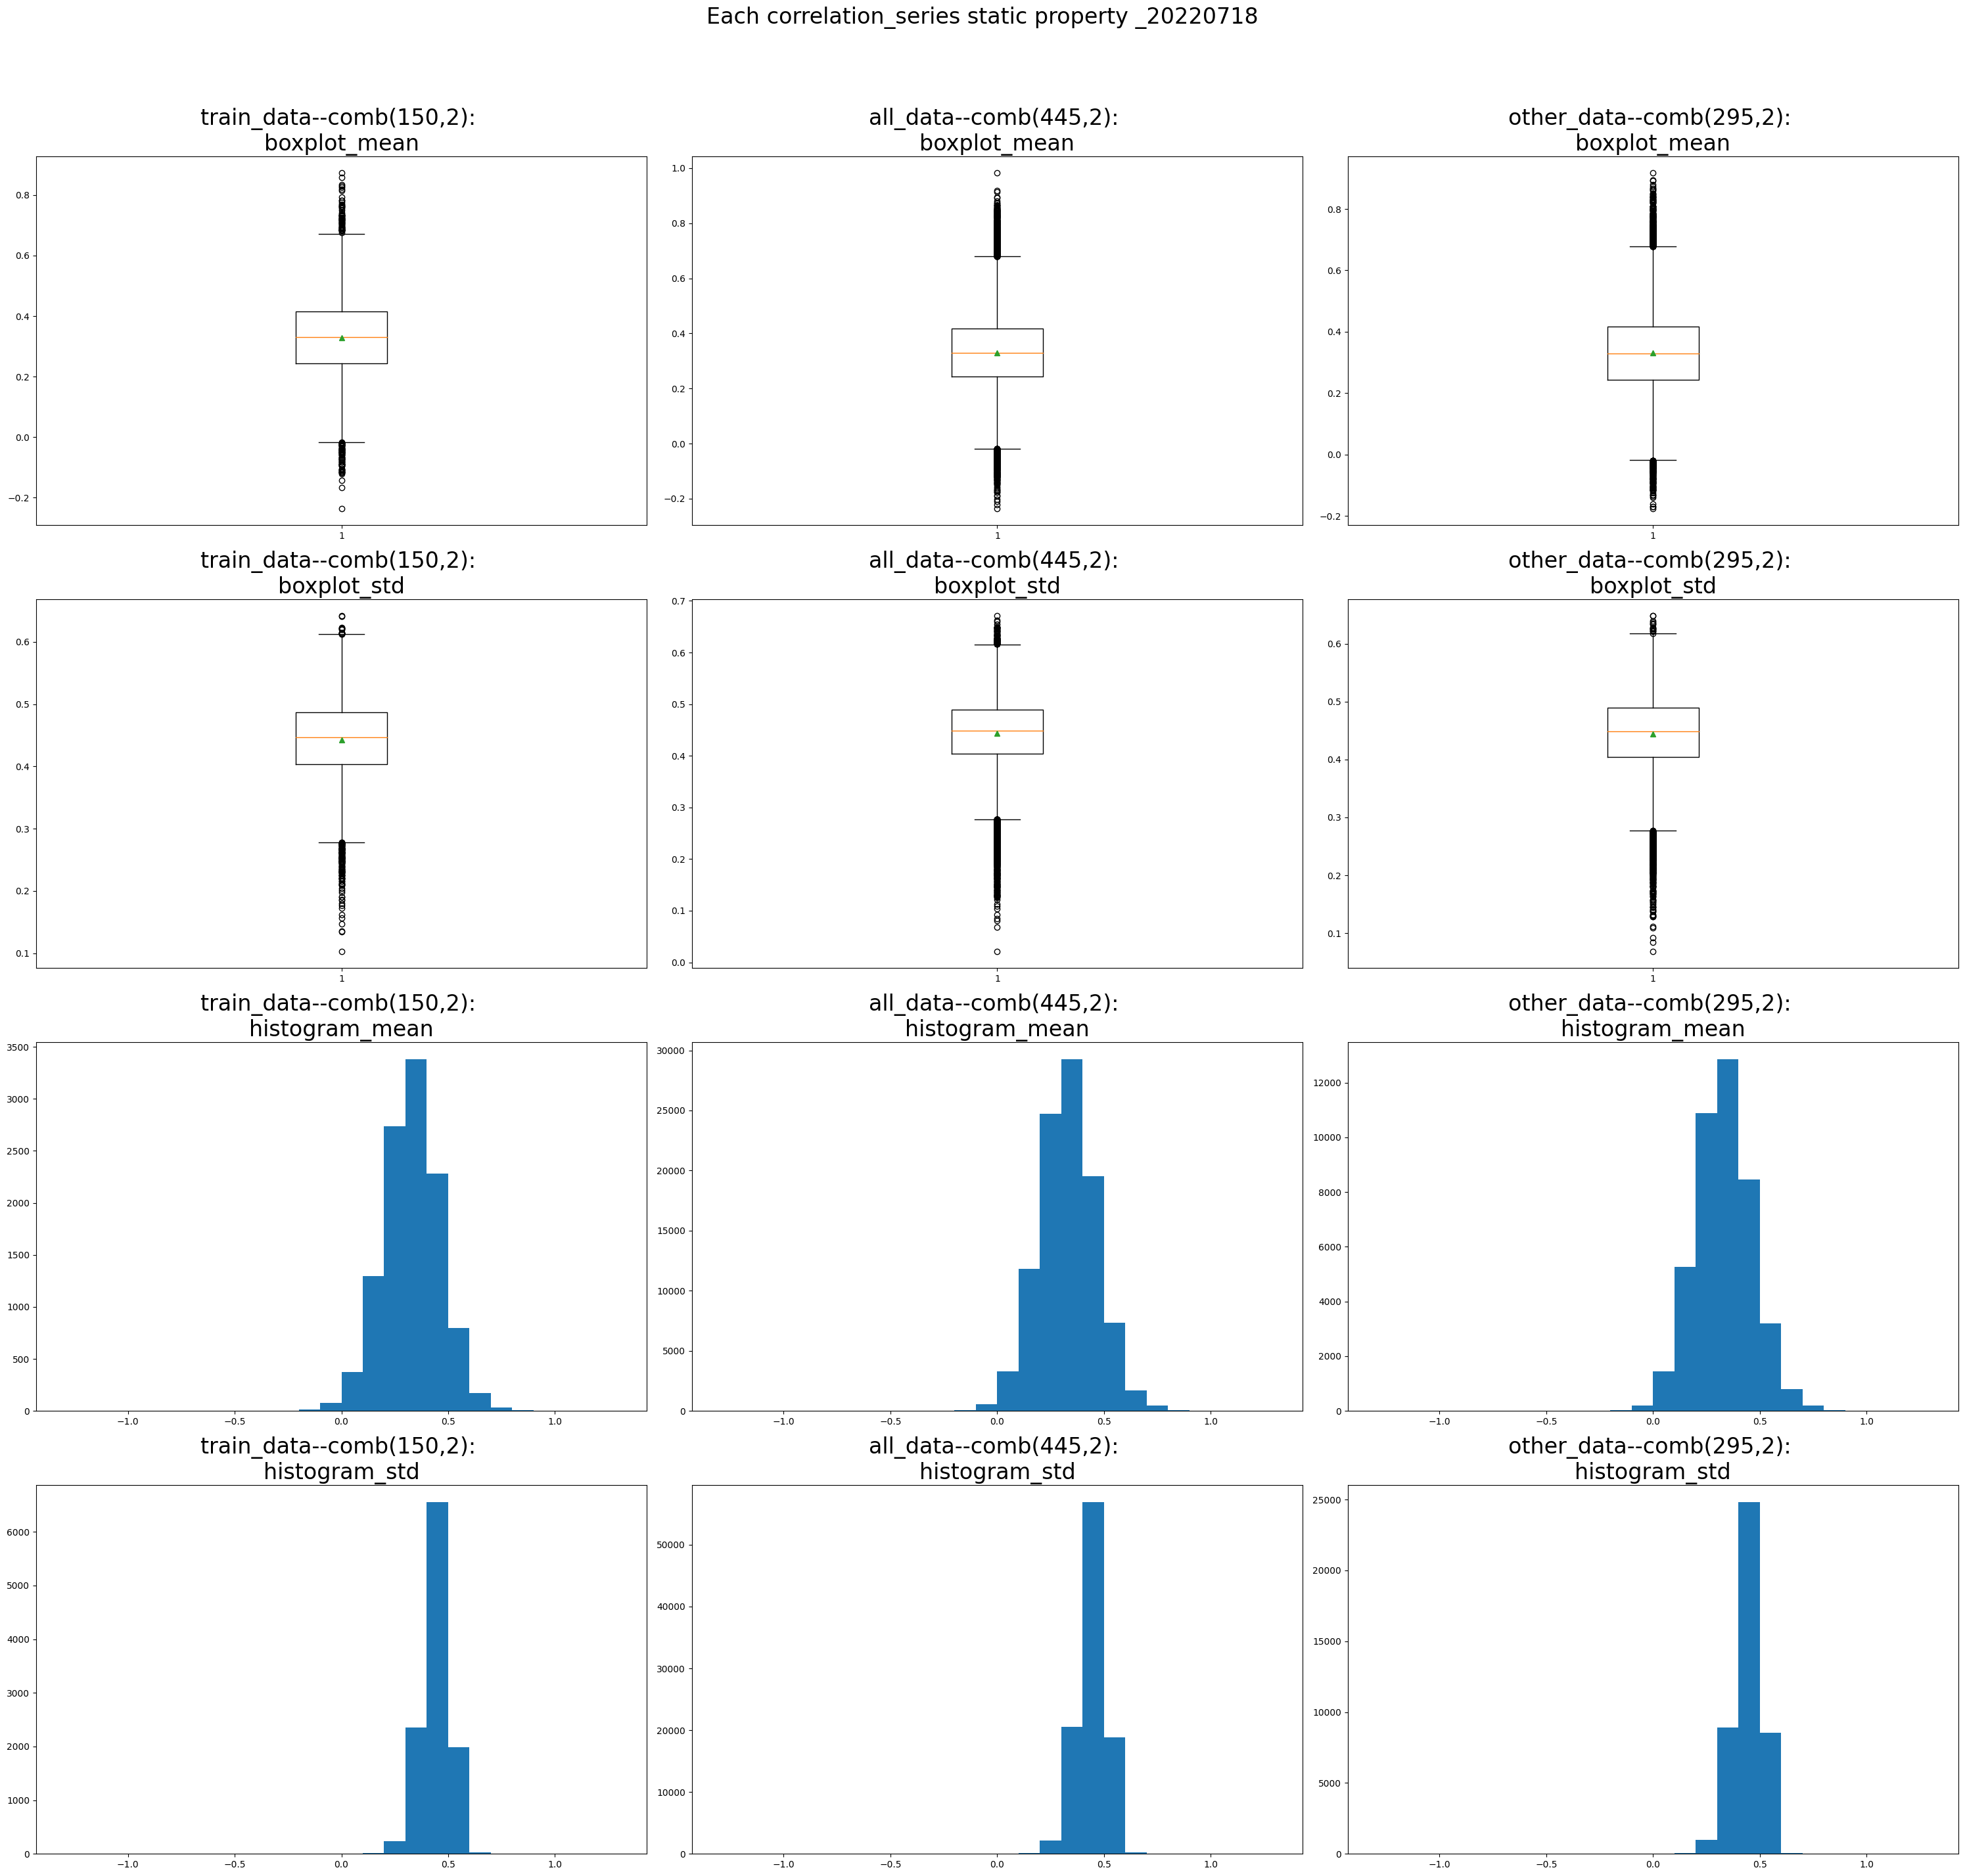

time: 9min 32s (started: 2022-07-18 15:33:38 +00:00)


In [14]:
datasets = {'train_data--comb(150,2)': train_corr_series_df, 'all_data--comb(445,2)': all_corr_series_df, 'other_data--comb(295,2)': other_corr_series_df}
etl_types = ["boxplot", "histogram"]
static_types = ["mean", "std"]
fig, axes = plt.subplots(figsize=(30, 30),nrows=len(list(product(etl_types, static_types))), ncols=len(datasets), sharex=False, sharey=False, dpi=100)

for row, (etl_type, static_type) in enumerate(product(etl_types, static_types)):
    for col,dataset_key in enumerate(datasets):
        s = axes[row, col]
        s.set_title(f"{dataset_key}: \n{etl_type}_{static_type}", fontsize=24)
        if etl_type=="boxplot":
            s.boxplot(datasets[dataset_key].iloc[:, ::5].describe().loc[static_type,:], showmeans=True)
        elif etl_type=="histogram":
            s.hist(datasets[dataset_key].iloc[:, ::5].describe().loc[static_type,:], bins=[b/10 for b in range(-13,14)])
            
fig.suptitle(f"Each correlation_series static property _20220718", fontsize=24)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# 分開, 避免子圖標籤互相重疊
# plt.tight_layout()
plt.savefig("./results/dataset_exploration_3.png")
plt.show()
plt.close()

In [15]:
display(train_corr_series_df)
display(train_corr_series_df.iloc[:,::5])
display(train_corr_series_df.iloc[:,::5].describe())
display(train_corr_series_df.iloc[:,::5].describe().loc['std',:])

,0,20,40,60,80,100,120,140,160,180,...,1117300,1117320,1117340,1117360,1117380,1117400,1117420,1117440,1117460,1117480
0,0.646860,0.518209,0.265099,-0.464590,-0.667206,-0.356145,-0.202976,-0.693420,-0.843329,-0.826591,...,0.396239,0.627391,0.850063,0.890753,0.876121,-0.098180,-0.368111,-0.167918,0.242583,0.802539
1,0.129343,0.757073,0.902180,0.851546,0.648949,-0.006025,0.775013,0.898395,0.842937,0.660141,...,0.870828,0.854808,0.820514,0.757564,0.754556,0.917817,0.937390,0.945463,0.937526,0.833362
2,0.076145,-0.301920,-0.516127,-0.536545,-0.300962,0.565409,0.267997,-0.065908,-0.478655,-0.293153,...,0.705180,0.650549,0.870403,0.854353,0.821601,0.071451,0.008614,0.243556,0.563173,0.684904
3,0.380201,0.729120,0.761980,0.802278,0.546734,0.304397,0.753708,0.696901,0.716963,0.610864,...,0.110969,0.063280,0.520852,0.762691,0.806614,0.595682,0.771566,0.921268,0.951715,0.943243
4,0.304520,0.594037,0.346457,0.220923,0.116298,0.334984,0.617741,0.561720,0.750150,0.678119,...,0.117950,-0.584284,-0.566581,-0.222365,0.713997,0.844499,0.850320,0.632534,0.386957,0.413954
5,0.135613,0.750661,0.833171,0.834689,0.713257,0.544597,0.654891,0.792444,0.868276,0.854704,...,0.857862,0.671333,0.398236,0.558067,0.763540,0.395403,0.710853,0.888777,0.900770,0.825214
6,0.645965,0.824905,0.863207,0.754435,0.249793,0.711449,0.884504,0.861153,0.820652,-0.283495,...,0.609642,0.838124,0.841148,0.725251,0.580435,0.425420,0.747234,0.786345,0.693917,0.344984
7,-0.263715,-0.427287,-0.190452,0.647995,0.917614,-0.799536,-0.765995,-0.388280,0.174396,0.057402,...,0.167442,-0.182337,-0.774457,-0.730393,0.215527,0.368931,0.502675,0.769699,0.734702,0.164792
8,0.841178,-0.008360,0.027634,0.317518,0.540427,-0.165908,0.301683,0.449232,0.309924,0.542536,...,0.392665,0.731043,0.632160,0.435792,0.234548,-0.337017,-0.560923,-0.418527,-0.149538,0.509582
9,0.513100,0.269781,0.289823,0.500881,0.665736,0.591869,0.704026,0.881065,0.938328,0.896868,...,0.168944,0.559820,0.867962,0.882026,0.809288,0.751782,0.607262,0.597815,0.623108,0.618142


,0,100,200,300,400,500,600,700,800,900,...,1116500,1116600,1116700,1116800,1116900,1117000,1117100,1117200,1117300,1117400
0,0.646860,-0.356145,-0.515433,0.649589,-0.426702,0.663749,0.158207,0.752652,0.732751,0.323402,...,-0.539597,0.598492,0.507066,-0.439962,0.804702,-0.002694,-0.255854,-0.579278,0.396239,-0.098180
1,0.129343,-0.006025,0.175213,0.517754,0.516695,-0.090260,0.217934,0.238879,0.211546,0.343979,...,0.706517,0.707512,0.715166,0.740578,0.394863,0.496105,0.418647,0.922820,0.870828,0.917817
2,0.076145,0.565409,0.629499,0.743672,0.593417,0.538072,0.394915,0.107038,0.695878,0.768150,...,0.113042,0.764332,0.815105,0.725107,0.070417,0.695999,0.772271,-0.245158,0.705180,0.071451
3,0.380201,0.304397,-0.668681,-0.331427,0.387405,0.190318,-0.017817,0.354005,-0.004741,0.291534,...,0.453203,0.921629,-0.058254,0.452065,0.452525,0.641900,0.581307,-0.123623,0.110969,0.595682
4,0.304520,0.334984,-0.044271,0.290294,-0.004883,0.525226,0.542018,0.412974,0.367095,0.412244,...,-0.797948,-0.549345,0.350197,-0.788425,0.881377,0.736519,-0.101038,-0.195334,0.117950,0.844499
5,0.135613,0.544597,0.442280,0.664944,0.503555,0.724335,0.294222,0.728991,-0.450233,0.522165,...,0.390358,0.302858,0.014277,0.410639,0.434051,0.680132,0.566588,0.233530,0.857862,0.395403
6,0.645965,0.711449,0.686972,0.277832,0.547280,0.553747,0.300959,0.167345,0.329671,0.695898,...,0.256809,0.684353,0.610205,0.341276,0.234174,0.601124,0.119404,0.552648,0.609642,0.425420
7,-0.263715,-0.799536,-0.175578,-0.800980,-0.391699,-0.576530,-0.659728,-0.842219,-0.862644,-0.788403,...,-0.097879,0.336472,0.750480,0.748564,0.074108,0.801352,0.570147,-0.471547,0.167442,0.368931
8,0.841178,-0.165908,-0.850958,-0.319675,0.237225,-0.510359,0.347077,0.753110,0.056400,0.942019,...,0.121884,0.699420,0.074684,0.653202,-0.359107,0.733863,0.530193,-0.715617,0.392665,-0.337017
9,0.513100,0.591869,-0.105252,0.637190,0.313150,0.398180,0.640164,0.322593,-0.328080,-0.390280,...,0.581679,0.580968,0.411382,0.852059,0.799323,0.798198,0.147756,-0.094099,0.168944,0.751782


,0,100,200,300,400,500,600,700,800,900,...,1116500,1116600,1116700,1116800,1116900,1117000,1117100,1117200,1117300,1117400
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.448508,0.307577,0.272518,0.377264,0.429720,0.285583,0.321756,0.231834,0.049870,0.358718,...,0.458522,0.368265,0.545686,0.400842,0.422386,0.543347,0.376386,0.349011,0.432091,0.408950
std,0.311960,0.428744,0.477866,0.455391,0.376389,0.407985,0.396018,0.490049,0.546301,0.495361,...,0.450988,0.486710,0.307301,0.469571,0.429465,0.356719,0.361062,0.511659,0.440001,0.481463
min,-0.263715,-0.799536,-0.850958,-0.800980,-0.426702,-0.576530,-0.659728,-0.842219,-0.862644,-0.788403,...,-0.797948,-0.678599,-0.058254,-0.788425,-0.399713,-0.704856,-0.561940,-0.715617,-0.506280,-0.836800
25%,0.180004,0.104316,-0.033112,0.168696,0.294168,0.087021,0.130693,-0.062302,-0.337189,0.152218,...,0.253848,0.153679,0.342314,0.181006,0.087710,0.480607,0.143029,-0.101480,0.155824,0.147310
50%,0.475642,0.421387,0.455573,0.596671,0.510125,0.372417,0.348219,0.280736,0.025829,0.467362,...,0.580376,0.514230,0.662686,0.581150,0.477877,0.679465,0.426892,0.552192,0.552039,0.561797
75%,0.653478,0.598163,0.659350,0.661498,0.694060,0.574610,0.567730,0.672317,0.420446,0.757506,...,0.826487,0.712768,0.788692,0.747086,0.800668,0.737486,0.572937,0.712416,0.822184,0.758653
max,0.917480,0.954869,0.807774,0.846603,0.933574,0.820802,0.898922,0.846217,0.922407,0.942019,...,0.931560,0.946846,0.925110,0.852059,0.950643,0.909497,0.915730,0.925777,0.870828,0.917817


0          0.311960
100        0.428744
200        0.477866
300        0.455391
400        0.376389
             ...   
1117000    0.356719
1117100    0.361062
1117200    0.511659
1117300    0.440001
1117400    0.481463
Name: std, Length: 11175, dtype: float64

time: 20 s (started: 2022-07-19 07:07:46 +00:00)
